In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [124]:
def lorenz(dt_out, x):
    dt = 0.001
    sigma = 10
    rho = 28
    beta = 8/3
    x_next = np.zeros(3)
    for j in range(int(dt_out/dt)):
        x_next[0] = x[0] + dt*sigma*(x[1] - x[0])
        x_next[1] = x[1] + dt*(x[0]*(rho - x[2]) - x[1])
        x_next[2] = x[2] + dt*(x[0]*x[1] - beta*x[2])
        x_next += np.sqrt(dt)*np.random.randn(3)
        x = x_next
    return x

def lorenz_vectorized(dt_out, x):
    dt = 0.001
    sigma = 10
    rho = 28
    beta = 8/3
    x_next = x.copy()
    for j in range(int(dt_out/dt)):
        x_next[:, 0] = x[:, 0] + dt*sigma*(x[:, 1] - x[:, 0])
        x_next[:, 1] = x[:, 1] + dt*(x[:, 0]*(rho - x[:, 2]) - x[:, 1])
        x_next[:, 2] = x[:, 2] + dt*(x[:, 0]*x[:, 1] - beta*x[:, 2])
        x_next += np.sqrt(dt)*np.random.randn(x_next.shape[0], x_next.shape[1])
        x[:, :] = x_next
    return x

def generate_path(z_0, N_steps, dt_out):
    ts = np.zeros(N_steps)
    trajectory = np.zeros((N_steps, 3))
    trajectory[0] = z_0
    #preallocate memory for current and next iterate
    x = trajectory[0]
    x_next = np.zeros(3)
    for i in range(1, N_steps):
        x = lorenz(dt_out, x)
        trajectory[i, :] = x
        ts[i] = i*dt_out
    return ts, trajectory

In [165]:
dt_out = 0.01
z_0 = np.array([-0.587, -0.563, 16.87])
ts, path = generate_path(z_0, 1000, dt_out)

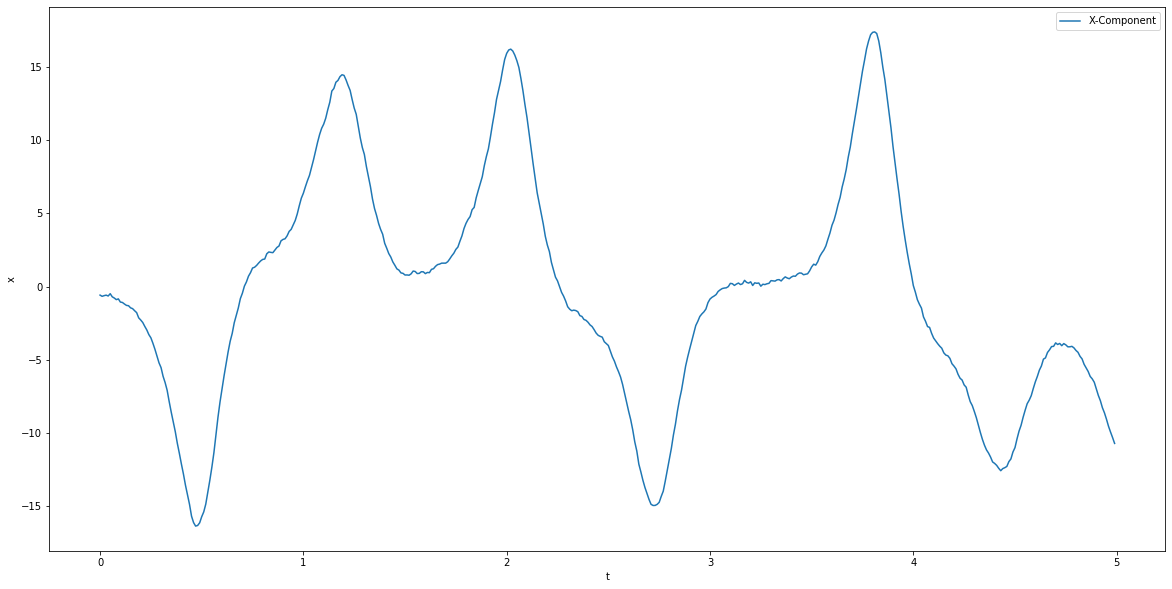

In [166]:
plt.figure(figsize=(20,10))
plt.plot(ts[:500], path[:500, 0], label="X-Component")
plt.xlabel("t")
plt.ylabel("x")
plt.legend()

In [167]:
def generate_observations(path, R):
    path_length = path.shape[0]
    return path[:, 0] + np.sqrt(R) * np.random.randn(path_length)

In [187]:
observations = generate_observations(path, 100)

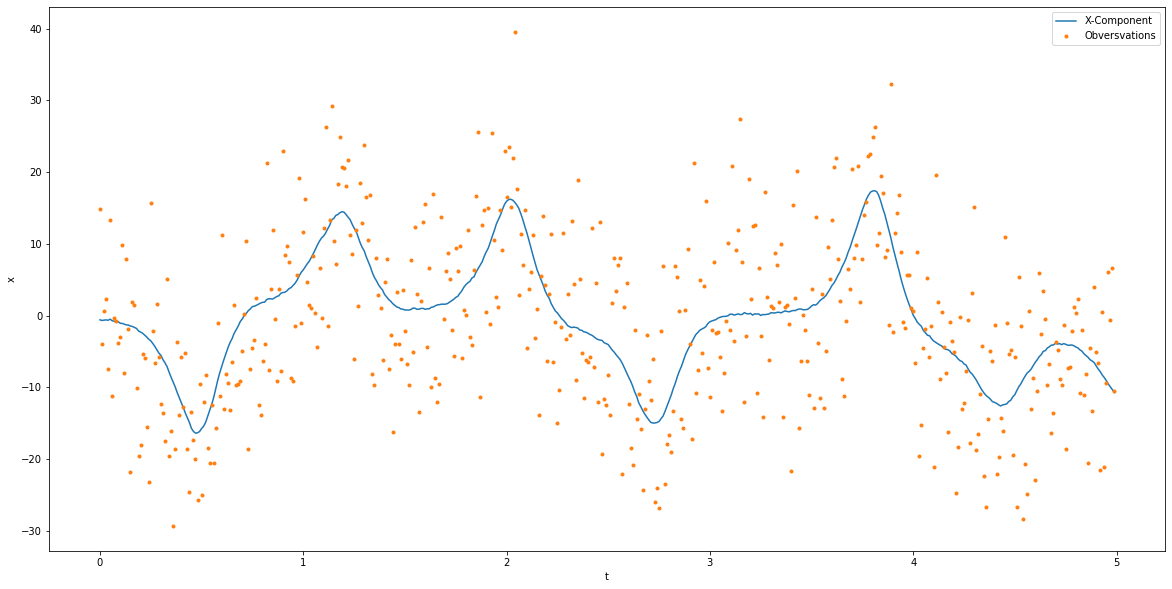

In [188]:
plt.figure(figsize=(20,10))
plt.plot(ts[:500], path[:500, 0], label="X-Component")
plt.plot(ts[:500], observations[:500], ".", label="Obversvations")
plt.xlabel("t")
plt.ylabel("x")
plt.legend()

In [118]:
def likelihood(ensemble, observation, R):
    exponents = (ensemble[:, 0] - observation)**2 / (2*R)
    return np.exp(-exponents)

def residual_resampling(ensemble, weights):
    N_weights = len(weights)
    N_ensemble = ensemble.shape[0]
    new_ensemble = ensemble.copy()
    new_ensemble_members = 0
    for i in range(N_weights):
        non_residual = int(np.floor(weights[i]*N_ensemble))
        for j in range(non_residual):
            new_ensemble[new_ensemble_members, :] = ensemble[i]
            new_ensemble_members += 1
        weights[i] = N_ensemble * weights[i] - non_residual
    
    if new_ensemble_members < N_ensemble:
        weights /= np.sum(weights)
        random_numbers = np.random.rand(N_ensemble - new_ensemble_members) # draw uniform samples
        cdf = np.cumsum(weights)           # calculate cdf from weights
        # see in which "bin" of cdf the random number falls
        new_ensemble[new_ensemble_members:, :] = ensemble[np.digitize(random_numbers, cdf)] # alternative for [np.argmin(cdf<number) for number in random_numbers]
    return new_ensemble
    

def SIR(ensemble_size, observations, R):
    ensemble = np.random.multivariate_normal(z_0, 0.01*np.eye(3), size=ensemble_size) # generate initial random samples
    N_observations = len(observations)
    N_ensemble = ensemble.shape[0]
    weights = np.ones(N_ensemble)/N_ensemble
    effective_sample_size = 0
    effective_sample_sizes = np.zeros(N_observations)
    analysis_mean = np.zeros((N_observations, 3))
    for i in range(N_observations):
        #reweight the ensemble with the likelihood
        likelihoods = likelihood(ensemble, observations[i], R)
        weights *= likelihoods
        weights /= np.sum(weights)
        
        #maybe resample
        effective_sample_size = 1/np.sum(weights**2)
        if effective_sample_size < N_ensemble/2:
            ensemble = residual_resampling(ensemble, weights)
            weights = np.ones(N_ensemble)/N_ensemble
        effective_sample_sizes[i] = 1/np.sum(weights**2)
        
        #move the ensemble forward and calculate analysis mean
        lorenz_vectorized(dt_out, ensemble)
#         for j in range(N_ensemble):
#             ensemble[j, :] = lorenz(dt_out, ensemble[j, :])
        analysis_mean[i, :] = weights.dot(ensemble)

    return effective_sample_sizes, analysis_mean

In [189]:
ss, mean = SIR(50, observations, 100)

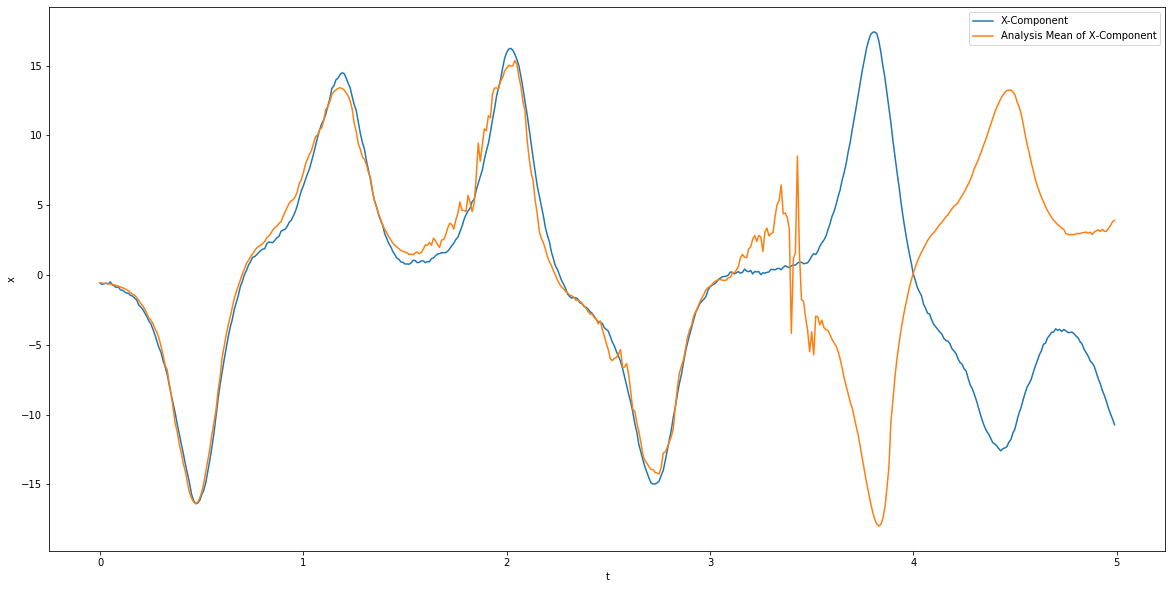

In [190]:
plt.figure(figsize=(20,10))
plt.plot(ts[:500], path[:500, 0], label="X-Component")
plt.plot(ts[:500], mean[:500, 0], label="Analysis Mean of X-Component")
plt.xlabel("t")
plt.ylabel("x")
plt.legend()

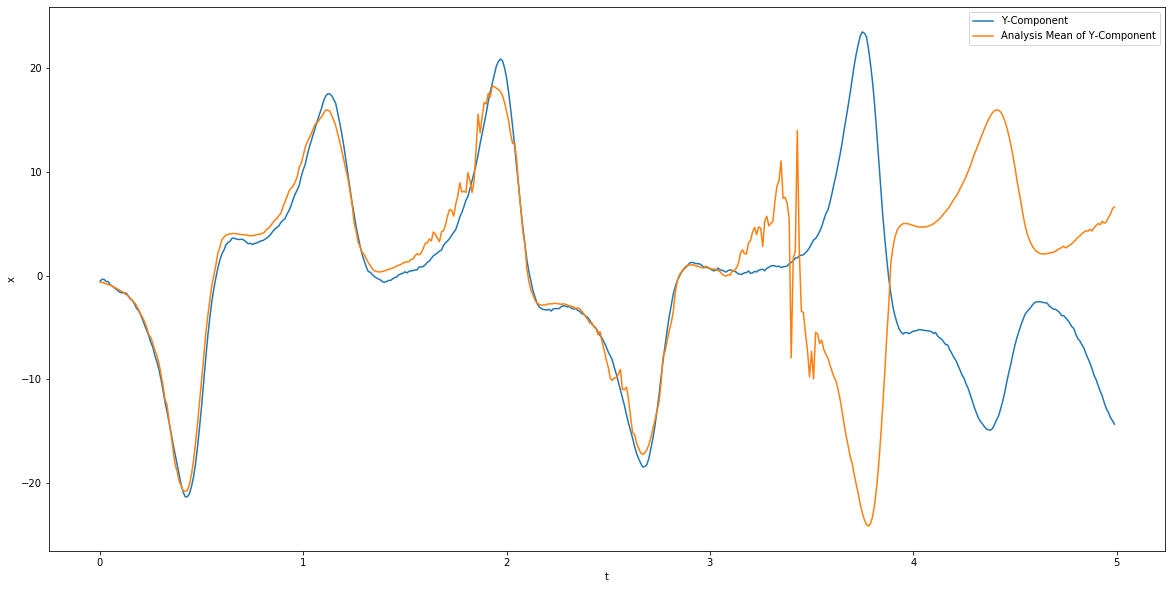

In [191]:
plt.figure(figsize=(20,10))
plt.plot(ts[:500], path[:500, 1], label="Y-Component")
plt.plot(ts[:500], mean[:500, 1], label="Analysis Mean of Y-Component")
plt.xlabel("t")
plt.ylabel("x")
plt.legend()

In [199]:
Rs = [0.1, 0.5, 1.0, 100]
Ms = [10, 20, 30, 40, 50, 75, 100, 150, 200]
RMSE = np.zeros((len(Rs), len(Ms)))
for i, R in enumerate(Rs):
    ts, path = generate_path(z_0, 1000, dt_out)
    observations = generate_observations(path, R)
    for j, M in enumerate(Ms):
        ss, mean = SIR(M, observations, R)
        err = np.sqrt(np.sum((mean - path)**2)/3000)
        RMSE[i, j] = err

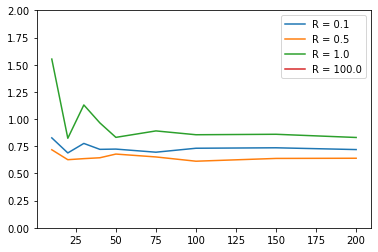

In [200]:
for i, R in enumerate(Rs):
    plt.plot(Ms, RMSE[i, :], label="R = %.1f" % R)
plt.ylim(0, 2)
plt.legend()